In [2]:
import imageio
import requests
import torch
from diffusers import AnimateDiffVideoToVideoPipeline, DDIMScheduler, MotionAdapter
from diffusers.utils import export_to_gif
from io import BytesIO
from PIL import Image
from diffusers.utils import export_to_gif, export_to_video
import os

# Load the motion adapter
adapter = MotionAdapter.from_pretrained("guoyww/animatediff-motion-adapter-v1-5-2", torch_dtype=torch.float16)
# load SD 1.5 based finetuned model
model_id = "SG161222/Realistic_Vision_V5.1_noVAE"
pipe = AnimateDiffVideoToVideoPipeline.from_pretrained(model_id, motion_adapter=adapter, torch_dtype=torch.float16).to("cuda")
scheduler = DDIMScheduler.from_pretrained(
    model_id,
    subfolder="scheduler",
    clip_sample=False,
    timestep_spacing="linspace",
    beta_schedule="linear",
    steps_offset=1,
)
pipe.scheduler = scheduler

# enable memory savings
pipe.enable_vae_slicing()
pipe.enable_model_cpu_offload()

# helper function to load videos
def load_video(file_path: str):
    images = []

    if file_path.startswith(('http://', 'https://')):
        # If the file_path is a URL
        response = requests.get(file_path)
        response.raise_for_status()
        content = BytesIO(response.content)
        vid = imageio.get_reader(content)
    else:
        # Assuming it's a local file path
        vid = imageio.get_reader(file_path)

    for frame in vid:
        pil_image = Image.fromarray(frame)
        images.append(pil_image)

    return images

video = load_video("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/animatediff-vid2vid-input-1.gif")

output = pipe(
    video = video,
    prompt="panda playing a guitar, on a boat, in the ocean, high quality",
    negative_prompt="bad quality, worse quality",
    guidance_scale=7.5,
    num_inference_steps=25,
    strength=0.5,
    generator=torch.Generator("cpu").manual_seed(42),
)
frames = output.frames[0]
output_path = "generated/20_v2v"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
export_to_video(frames, output_path+".mp4")
export_to_gif(frames, output_path+".gif")

The config attributes {'motion_activation_fn': 'geglu', 'motion_attention_bias': False, 'motion_cross_attention_dim': None} were passed to MotionAdapter, but are not expected and will be ignored. Please verify your config.json configuration file.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

The config attributes {'center_input_sample': False, 'flip_sin_to_cos': True, 'freq_shift': 0, 'mid_block_type': 'UNetMidBlock2DCrossAttn', 'only_cross_attention': False, 'attention_head_dim': 8, 'dual_cross_attention': False, 'class_embed_type': None, 'num_class_embeds': None, 'upcast_attention': False, 'resnet_time_scale_shift': 'default', 'resnet_skip_time_act': False, 'resnet_out_scale_factor': 1.0, 'time_embedding_type': 'positional', 'time_embedding_dim': None, 'time_embedding_act_fn': None, 'timestep_post_act': None, 'conv_in_kernel': 3, 'conv_out_kernel': 3, 'class_embeddings_concat': False, 'mid_block_only_cross_attention': None, 'cross_attention_norm': None, 'addition_embed_type_num_heads': 64} were passed to UNetMotionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


  0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


'generated/20_v2v.gif'

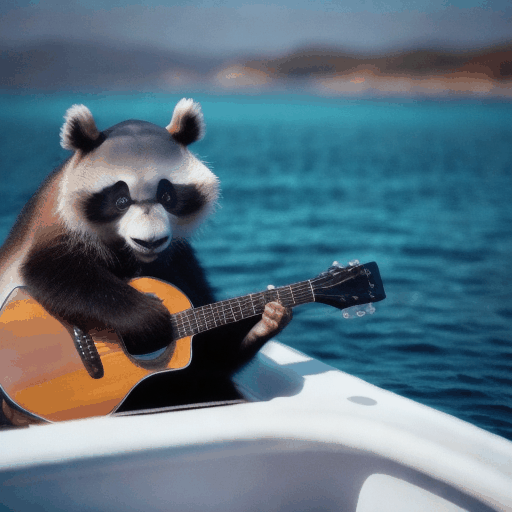

In [3]:
from IPython.display import Image

Image(output_path+".gif")

In [ ]:
## 7.2GB